In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload the ZIP file

Saving archive (3).zip to archive (3).zip


In [ ]:
import zipfile
import os

zip_path = next(iter(uploaded))  # Gets the uploaded file name
extract_path = "unzipped_data"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
])

# Dataset from folder
dataset = datasets.ImageFolder(root=extract_path, transform=transform)

# Dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Path to your actual image folders
data_path = "/content/unzipped_data/animals/animals"

# Load the dataset
dataset = datasets.ImageFolder(data_path, transform=train_transform)

# Split into train/test (e.g., 80% train, 20% test)
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=2, shuffle=False)

# Class names
class_names = dataset.classes
print(class_names)
print(f"Training images: {len(train_data)}")
print(f"Testing images: {len(test_data)}")


['cats', 'dogs', 'panda']
Training images: 2400
Testing images: 600


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
VGG19model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 85.9MB/s]


In [ ]:
# Freeze feature parameters
for param in VGG19model.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
VGG19model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 3),  # 3 classes now
    nn.LogSoftmax(dim=1)
)

In [ ]:
for param in VGG19model.parameters():
    print(param.numel())

1728
64
36864
64
73728
128
147456
128
294912
256
589824
256
589824
256
589824
256
1179648
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
2359296
512
25690112
1024
3072
3


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG19model.classifier.parameters(), lr=0.001)

In [ ]:
# Set time tracking
import time
start_time = time.time()

epochs = 3
max_trn_batch = 2400  # As per your dataset size
max_tst_batch = 600  # As per your test dataset size

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1

        # X_train, y_train = X_train.to(device), y_train.to(device)

        # Apply the model
        y_pred = VGG19model(X_train)
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  # Print interim results
        if b%20==0:
          acc = trn_corr.item()*100 / ((b+1)*train_loader.batch_size)
          print(f'epoch: {i+1}  batch: {b+1} loss: {loss.item():.4f} accuracy: {acc:.2f}%')


    train_losses.append(loss)
    train_correct.append(trn_corr)

    # X_test, y_test = X_test.to(device), y_test.to(device)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = VGG19model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch: 1  batch: 21 loss: 1.9239 accuracy: 66.67%
epoch: 1  batch: 41 loss: 0.0000 accuracy: 81.10%
epoch: 1  batch: 61 loss: 0.0095 accuracy: 86.48%
epoch: 1  batch: 81 loss: 0.0000 accuracy: 88.27%
epoch: 1  batch: 101 loss: 0.0000 accuracy: 89.60%
epoch: 1  batch: 121 loss: 0.0001 accuracy: 90.70%
epoch: 1  batch: 141 loss: 0.0000 accuracy: 91.84%
epoch: 1  batch: 161 loss: 0.0000 accuracy: 92.86%
epoch: 1  batch: 181 loss: 0.0000 accuracy: 92.96%
epoch: 1  batch: 201 loss: 0.0000 accuracy: 93.16%
epoch: 1  batch: 221 loss: 0.0959 accuracy: 93.10%
epoch: 1  batch: 241 loss: 7.5109 accuracy: 92.74%
epoch: 1  batch: 261 loss: 0.0000 accuracy: 93.01%
epoch: 1  batch: 281 loss: 0.0002 accuracy: 93.42%
epoch: 1  batch: 301 loss: 0.0000 accuracy: 93.60%
epoch: 1  batch: 321 loss: 1.4544 accuracy: 93.38%
epoch: 1  batch: 341 loss: 0.0000 accuracy: 93.55%
epoch: 1  batch: 361 loss: 0.0000 accuracy: 93.63%
epoch: 1  batch: 381 loss: 0.0000 accuracy: 93.64%
epoch: 1  batch: 401 loss: 0.0021 a

In [ ]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(566), tensor(590), tensor(575)]
Test accuracy: 95.833%


In [ ]:
# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

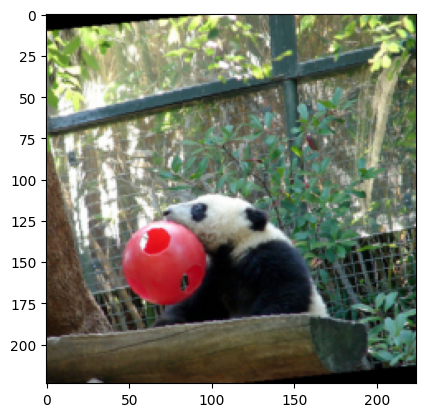

In [ ]:
image_index = 16
im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));
plt.show()

In [ ]:
# VGG19 Model Prediction:

VGG19model.eval()
with torch.no_grad():
    new_pred = VGG19model(test_data[image_index][0].view(1,3,224,224)).argmax()

class_names[new_pred.item()]

'panda'

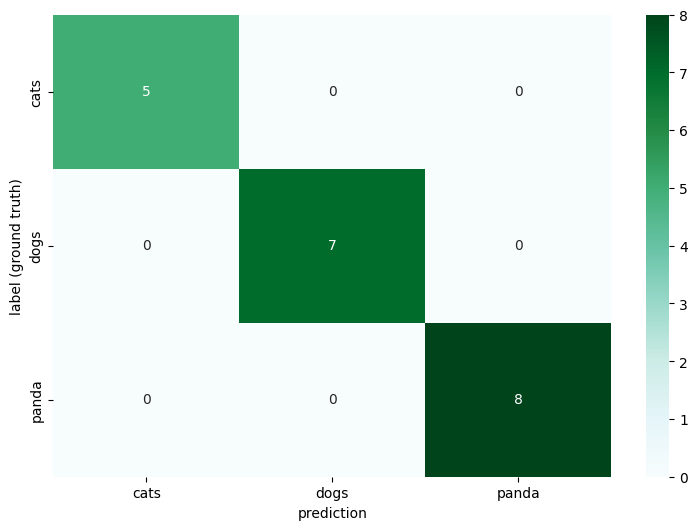

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=20, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = VGG19model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)

plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();